This dataset, which is from https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download, takes data that comes from a customer retention program.

They find out that the cost of retaining an existing customer is far less than acquiring a new one.

So our goal is to build a classifier that could takes in existing data, which information is introduced later, to predict if a customer will leave or remain.

For the dataset, each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn

Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

Demographic info about customers – gender, age range, and if they have partners and dependents

[1. Data](#data)

   *[1.1 Data Overview](#dataoverview)

[2. Data Manipulation](#datamanipulation)

[3. Data Preprocessing](#datapreprocessing)

[4. Data Analysis](#dataanalysis)

   *[4.1 Summary of Variables](#summaryofvariables)
   
   *[4.2 Correlation Matrix](#correlationmatrix)
   
   *[4.3 Customer Attrition Plot](#customerattrition)
   
   *[4.4 Binary Variable Distribution in Customer Attrition](#binaryvariabledistribution)

[5. Building Model](#buildingmodel)

   *[5.1 KNN Classifier](#knnclassifier)

[6. Model Performance](#modelperformance)

   *[6.1 Model Performance Metric](#modelperformancemetric)
        
   *[6.2 Confusion Matrix](#confusionmatrix)
       
   *[6.3 ROC Curve](#ROCcurve)
   
   *[6.4 Precision-Recall Curve](#precisionrecallcurve)

In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

## 1.Data<a id='data'></a>

In [114]:
telcom = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
#first few rows
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.1 Data Overview<a id='dataoverview'></a>

In [3]:
print ("Rows : " ,telcom.shape[0])
print ("Columns : " ,telcom.shape[1])
print ("\nFeatures : \n" ,telcom.columns.tolist())
print ("\nMissing values : ", telcom.isnull().sum().values.sum())
print ("\nUnique values : \n",telcom.nunique())

Rows :  7043
Columns :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :  0

Unique values : 
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [4]:
#summary of dataframe
telcom.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 2. Data Manipulation<a id='datamanipulation'></a> 

In [4]:
#Data Manipulation

#Replacing spaces with null in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ", np.nan)

#Dropping null values from total charges column 
telcom = telcom[telcom["TotalCharges"].notnull()]

#Reframe the index
telcom = telcom.reset_index()[telcom.columns]

#convert TotalCharges column to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for i in replace_cols:
    telcom[i] = telcom[i].replace({'No internet service':'No'})
 
#replace 1 and 0 in SeniorCitizen column with yes and no
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes", 0:"No"})

#Change Tenure Column into Categorical Variable
def tenure_lab(telcom) :
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom), axis = 1)

#Separating churn and non churn customers
churn = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
#customer id col
Id_col = ['customerID']

#target column
target_col = ["Churn"]

#categorical columns
cat_cols = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]

#numerical columns
num_cols = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

#Binary columns with 2 values
bin_cols = telcom.nunique()[telcom.nunique() == 2].keys().tolist()

#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

## 3. Data Preprocessing<a id='datapreprocessing'></a> 

In [5]:
#Since it's binary, Use label encoder to assign 0,1 to the binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
 
#one-hot encode columns with more than 2 values
telcom = pd.get_dummies(data = telcom, columns = multi_cols )

#standard scale numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled, columns = num_cols)

#dropping original numerical column
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)

#merge dataframe with scaled numerical column
telcom = telcom.merge(scaled, left_index = True, right_index = True, how = "left")

## 4. Data Analysis<a id='dataanalysis'></a> 

### 4.1 Summary of Variables<a id='summaryofvariables'></a>

In [6]:
#print all the varible summary except the index column
summary = (telcom[[i for i in telcom.columns if i not in Id_col]].describe().transpose().reset_index())

#rename the index column with "feature"
summary = summary.rename(columns = {"index":"feature"})

#round the result to three decimal place
summary = np.around(summary,3)
val_lst = [summary['feature'], summary['count'], summary['mean'], 
           summary['std'], summary['min'], summary['25%'], 
           summary['50%'], summary['75%'], summary['max']]
trace = go.Table(header = dict(values = summary.columns.tolist(), 
                               line = dict(color = ['#506784']), fill = dict(color = ['#119DFF'])),
                 cells = dict(values = val_lst, 
                              line = dict(color = ['#506784']),
                              fill = dict(color = ["lightgrey",'#F5F8FF'])),
                 columnwidth = [200,60,100,100,60,60,80,80,80])

#layout the table
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)


### 4.2 Correlation Matrix<a id='correlationmatrix'></a>

In [8]:
#correlation
correlation = telcom.corr()

#tick labels
matrix_cols = correlation.columns.tolist()

#convert correlation matrix to array
corr_array = np.array(correlation)

#Plot the correlation array
trace = go.Heatmap(z = corr_array, 
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar = dict(title = "Pearson Correlation coefficient",
                                   titleside = "right"))

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height = 720,
                        width = 800,
                        margin = dict(r = 0, l = 210, t = 25, b = 210),
                        yaxis = dict(tickfont = dict(size = 9)),
                        xaxis = dict(tickfont = dict(size = 9))))
data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

### 4.3 Customer Attrition Plot<a id='customerattrition'></a>

In [9]:
#labels
lab = ["Customers didn't leave within the last month--Churn = 0", "Customers left within the last month--Churn = 1"]

#values
val = telcom["Churn"].value_counts().values.tolist()

#print the pie plot
trace = go.Pie(labels = lab, 
               values = val, 
               marker = dict(colors = ['royalblue', 'lime'], 
                             line = dict(color = "white", width = 1.3)),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5)

layout = go.Layout(dict(title = "Customer Attrition--Those who left and those who remain", 
                        plot_bgcolor = "rgb(243,243,243)", paper_bgcolor = "rgb(243,243,243)"))

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)


### 4.4 Binary Variable Distribution in Customer Attrition<a id='binaryvariabledistribution'></a>

In [10]:
#separating binary columns from the preprocessed dataframe
bin_cols = telcom.nunique()[telcom.nunique() == 2].keys()
dat_rad = telcom[bin_cols]

#plotting radar chart for churn and non churn customers(binary variables)
def plot_radar(df, aggregate, title):
    #select all rows for which churn == aggregrate
    data_frame = df[df["Churn"] == aggregate]
    #count the number of yes in each binary column and make it a dataframe
    data_frame_x = data_frame[bin_cols].sum().reset_index()
    #rename the columns index and 0 with "feature" and "yes"
    data_frame_x.columns = ["feature", "yes"]
    #add a column "no" which is the sum of total column value minus yes value
    data_frame_x["no"] = data_frame.shape[0] - data_frame_x["yes"]
    #remove our target Churn from the dataframe
    data_frame_x = data_frame_x[data_frame_x["feature"] != "Churn"]
 
    #count of 1's(yes)
    trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
                         theta = data_frame_x["feature"].tolist(),
                         fill = "toself",
                         name = "count of Yes for different features",
                         mode = "markers+lines",
                         marker = dict(size = 5))

    #count of 0's(No)
    trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(), 
                         theta = data_frame_x["feature"].tolist(),
                         fill = "toself", 
                         name = "count of No for different features",
                         mode = "markers+lines",
                         marker = dict(size = 5))

    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                       side = "counterclockwise",
                                                       showline = True,
                                                       linewidth = 2,
                                                       tickwidth = 2,
                                                       gridcolor = "white",
                                                       gridwidth = 2),
                                     angularaxis = dict(tickfont = dict(size = 10),
                                                        layer = "below traces"),
                                     bgcolor = "rgb(243,243,243)"),
                        paper_bgcolor = "rgb(243,243,243)",
                        title = title,
                        height = 700))
 
    data = [trace2, trace1]
    fig = go.Figure(data = data,layout = layout)
    py.iplot(fig)

#plot
plot_radar(dat_rad, 1 , "Customers who left within the last month--Churn")
plot_radar(dat_rad, 0 , "Customers didn't leave within the last month--No Churn")

## 5. Building Model<a id='buildingmodel'></a> 

In [19]:
#splitting train and test data 
train, test = train_test_split(telcom, test_size = .25, random_state = 666)
 
#seperating X and Y(our target Churn)
cols = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X = test[cols]
test_Y = test[target_col]

### 5.1 KNN Classifier<a id='knnclassifier'></a>

In [12]:
#initiate a KNN model
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=5, p=2, weights='uniform') 

#fit the model to our train_X and train_Y data
knn.fit(train_X,train_Y)

#predict class labels for test_X
predictions = knn.predict(test_X)
#Return probability estimates for test_X
probabilities = knn.predict_proba(test_X)

#print the KNN Classifier Classification Report
print ("K-Nearest Neighbors Classifier")
print ("\n Classification report : \n", classification_report(test_Y, predictions))
print ("Accuracy Score : ", accuracy_score(test_Y, predictions))
#confusion matrix
conf_matrix = confusion_matrix(test_Y,predictions)
#roc_auc_score
model_roc_auc = roc_auc_score(test_Y,predictions)
print ("Area under curve : ",model_roc_auc)
fpr,tpr,thresholds = roc_curve(test_Y,probabilities[:,1])
 
#plot roc curve
trace1 = go.Scatter(x = fpr,y = tpr,
name = "Roc : " + str(model_roc_auc),
line = dict(color = ('rgb(22, 96, 167)'),width = 2),
)
trace2 = go.Scatter(x = [0,1],y=[0,1],
line = dict(color = ('rgb(205, 12, 24)'),width = 2,
dash = 'dot'))
 
#plot confusion matrix
trace3 = go.Heatmap(z = conf_matrix ,x = ["Not churn","Churn"],
y = ["Not churn","Churn"],
showscale = True,colorscale = "Blues",name = "matrix",
xaxis = "x2",yaxis = "y2"
)
 
layout = go.Layout(dict(title="Model performance" ,
autosize = False,height = 500,width = 800,
showlegend = False,
plot_bgcolor = "rgb(243,243,243)",
paper_bgcolor = "rgb(243,243,243)",
xaxis = dict(title = "false positive rate",
gridcolor = 'rgb(255, 255, 255)',
domain=[0, 0.6],
ticklen=5,gridwidth=2),
yaxis = dict(title = "true positive rate",
gridcolor = 'rgb(255, 255, 255)',
zerolinewidth=1,
ticklen=5,gridwidth=2),
margin = dict(b=200),
xaxis2=dict(domain=[0.7, 1],tickangle = 90,
gridcolor = 'rgb(255, 255, 255)'),
yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')))
    
data = [trace1,trace2,trace3]
fig = go.Figure(data=data,layout=layout)
 
py.iplot(fig)

K-Nearest Neighbors Classifier

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1303
           1       0.58      0.49      0.53       455

    accuracy                           0.77      1758
   macro avg       0.70      0.68      0.69      1758
weighted avg       0.76      0.77      0.77      1758

Accuracy Score :  0.7747440273037542
Area under curve :  0.6806929064795527


## 6. Model Performance<a id='modelperformance'></a>

### 6.1 Model Performance Metric<a id='modelperformancemetric'></a>

In [13]:
knn.fit(train_X,train_Y)
predictions = knn.predict(test_X)
accuracy = accuracy_score(test_Y, predictions)
recallscore = recall_score(test_Y, predictions)
precision = precision_score(test_Y, predictions)
roc_auc = roc_auc_score(test_Y, predictions)
f1score = f1_score(test_Y, predictions)
kappa_metric = cohen_kappa_score(test_Y, predictions)
 
df = pd.DataFrame({"Model" : ["KNN Classifier"], 
                   "Accuracy_score" : [accuracy],
                   "Recall_score" : [recallscore],
                   "Precision" : [precision],
                   "f1_score" : [f1score],
                   "Area_under_curve": [roc_auc],
                   "Kappa_metrics" : [kappa_metric]})


In [14]:
table = ff.create_table(np.round(df,4))
py.iplot(table)

### 6.2 Confusion Matrix<a id='confusionmatrix'></a>

Text(0.5, 1.0, 'Confusion Matrix for K_Nearest Neighbors Classifier')

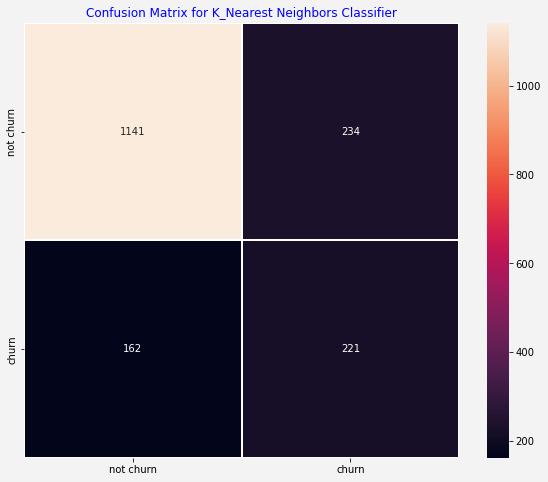

In [15]:
fig = plt.figure(figsize=(10,8))
fig.set_facecolor("#F3F3F3")
predictions = knn.predict(test_X)
conf_matrix = confusion_matrix(predictions,test_Y)
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt = "d", 
            square = True, 
            xticklabels=["not churn","churn"],
            yticklabels=["not churn","churn"],
            linewidths = 2,
            linecolor = "w")
plt.title('Confusion Matrix for K_Nearest Neighbors Classifier', color = "b")

### 6.3 ROC Curve<a id='ROCcurve'></a>

([<matplotlib.axis.YTick at 0x2950cb87fa0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

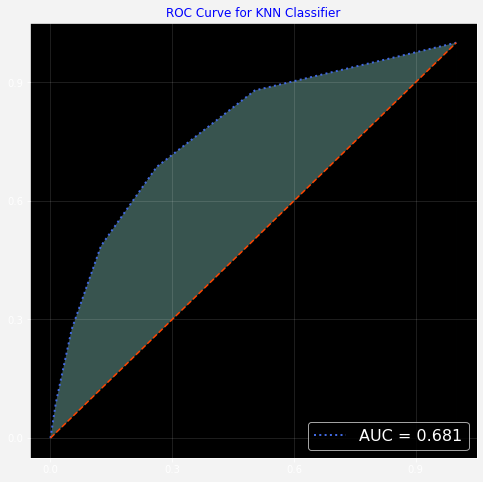

In [16]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#F3F3F3")

probabilities = knn.predict_proba(test_X)
predictions = knn.predict(test_X)
fpr,tpr,thresholds = roc_curve(test_Y, probabilities[:,1])
plt.plot(fpr,
         tpr,
         linestyle = "dotted",
         color = "royalblue",
         linewidth = 2,
         label = "AUC = " + str(np.around(roc_auc_score(test_Y, predictions), 3)))

plt.plot([0,1],[0,1],linestyle = "dashed",
color = "orangered",linewidth = 1.5)
plt.fill_between(fpr, tpr, alpha = .4)
plt.fill_between([0,1], [0,1], color = "k")
plt.legend(loc = "lower right",
prop = {"size" : 16})
plt.grid(True,alpha = .15)
plt.title("ROC Curve for KNN Classifier",color = "b")
plt.xticks(np.arange(0,1,.3))
plt.yticks(np.arange(0,1,.3))

### 6.4  Precision-Recall Curve<a id='precisionrecallcurve'></a>

([<matplotlib.axis.YTick at 0x2950cffbd90>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

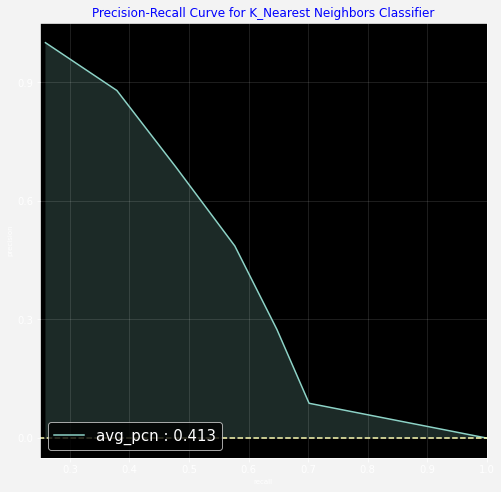

In [17]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#F3F3F3") 
probabilities = knn.predict_proba(test_X)
predictions = knn.predict(test_X)
recall, precision, thresholds = precision_recall_curve(test_Y, probabilities[:,1])
plt.plot(recall, precision, linewidth = 1.5,
         label = ("avg_pcn : " + str(np.around(average_precision_score(test_Y,predictions),3))))
plt.plot([0,1],[0,0],linestyle = "dashed")
plt.fill_between(recall,precision,alpha = .2)
plt.legend(loc = "lower left",
prop = {"size" : 15})
plt.grid(True,alpha = .15)
plt.title("Precision-Recall Curve for K_Nearest Neighbors Classifier",color = "b")
plt.xlabel("recall",fontsize =7)
plt.ylabel("precision",fontsize =7)
plt.xlim([0.25,1])
plt.yticks(np.arange(0,1,.3))

In [241]:
telcom = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
#first few rows
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### PCA and Clustering

In [242]:
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ", np.nan)

#Dropping null values from total charges column 
telcom = telcom[telcom["TotalCharges"].notnull()]

#Reframe the index
telcom = telcom.reset_index()[telcom.columns]

#convert TotalCharges column to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for i in replace_cols:
    telcom[i] = telcom[i].replace({'No internet service':'No'})
 
#replace 1 and 0 in SeniorCitizen column with yes and no
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes", 0:"No"})

#Change Tenure Column into Categorical Variable

#Separating churn and non churn customers
churn = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
#customer id col
Id_col = ['customerID']

#target column
target_col = ["Churn"]

#categorical columns
cat_cols = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]

#numerical columns
num_cols = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

#Binary columns with 2 values
bin_cols = telcom.nunique()[telcom.nunique() == 2].keys().tolist()

#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]


In [243]:
le=LabelEncoder()
cat_cols=telcom.select_dtypes(exclude=['int','float']).columns
enc_data=list(cat_cols)
telcom[enc_data]=telcom[enc_data].apply(lambda col:le.fit_transform(col))
scale=StandardScaler()
telcoms=scale.fit_transform(telcom.iloc[:,1:20])
telcom_df=pd.DataFrame(telcoms)
telcom_df['Churn'] = telcom.iloc[:,20]

In [244]:
train, test = train_test_split(telcom, test_size = .25, random_state = 666)
 
#seperating X and Y(our target Churn)
cols = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X = test[cols]
test_Y = test[target_col]

trains, tests = train_test_split(telcom_df, test_size = .25, random_state = 666)
cols = [i for i in telcom.columns if i not in Id_col + target_col]
trains_X = trains.iloc[:,0:19]
trains_Y = trains[target_col]
tests_X = tests.iloc[:,0:19]
tests_Y = tests[target_col]

For n_clusters = 2, silhouette score is 0.7043247708995602)
For n_clusters = 3, silhouette score is 0.6463827905567306)
For n_clusters = 4, silhouette score is 0.5985380983480234)
For n_clusters = 5, silhouette score is 0.5949215734906365)
For n_clusters = 6, silhouette score is 0.5946590147607473)
For n_clusters = 7, silhouette score is 0.5848242351202735)
For n_clusters = 8, silhouette score is 0.5737595845380115)
For n_clusters = 9, silhouette score is 0.5651647987864643)
For n_clusters = 10, silhouette score is 0.5632700426602137)
For n_clusters = 11, silhouette score is 0.562774304599752)
For n_clusters = 12, silhouette score is 0.5613141680561303)
For n_clusters = 13, silhouette score is 0.5508440568649494)
For n_clusters = 14, silhouette score is 0.5478502123935284)


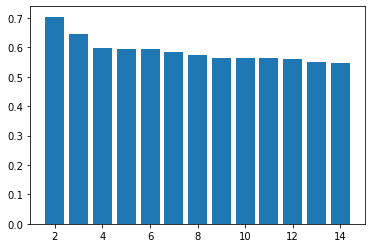

In [199]:
from sklearn.metrics import silhouette_score
score_list=[]
for n_clusters in range(2,15):
        clusterer = KMeans(n_clusters=n_clusters).fit(train_X)
        preds = clusterer.predict(train_X)
        centers = clusterer.cluster_centers_

        score = silhouette_score (train_X, preds, metric='euclidean')
        score_list.append(score)
        print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

plt.bar(range(2,15),score_list)
plt.show()

In [252]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
pc=pca.fit_transform(trains_X)
print(pca.explained_variance_ratio_)
pdf=pd.DataFrame(data=pc,columns=['principal component 1','principal component 2'])

[0.26099766 0.11953397]


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

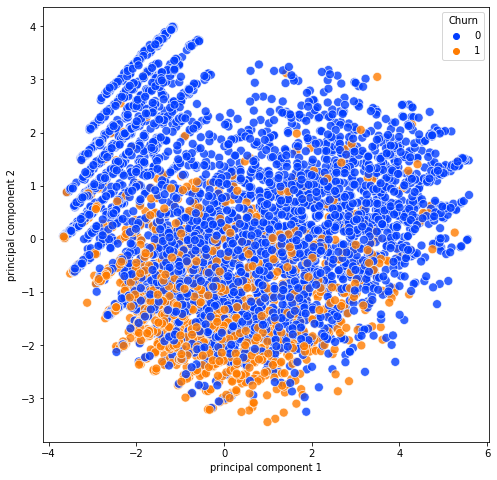

In [300]:
trains_Y = trains_Y.reset_index().iloc[:,1]
tests_Y = tests_Y.reset_index().iloc[:,1]
data=pd.concat([pdf,trains_Y],axis=1)

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(x = data.iloc[:,0], y = data.iloc[:,1], hue = data.iloc[:,2],
                s = 80, alpha = 0.8, palette='bright', ax = ax)

In [287]:
# Import KMeans from sklearn
from sklearn.cluster import KMeans

# Intantiate a KMeans object which will generate 10 clusters.
# Use init='k-means++' and random_state=123
# Store as 'km'.
km = KMeans(n_clusters = 2, init='k-means++', random_state=123)

# Use .fit_predict() on X_digits to both fit our k-means model and generate cluster assignments.
# Store the result as cluster_assignments.
cluster_assignments = km.fit_predict(train_X)

# print the first 10 cluster assignments
print(cluster_assignments[:10])

[1 0 0 0 0 0 0 0 1 0]


In [291]:
test_cluster = km.predict(test_X)
print("test accuracy is ",sum(test_cluster == test_Y.squeeze())/1758)

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

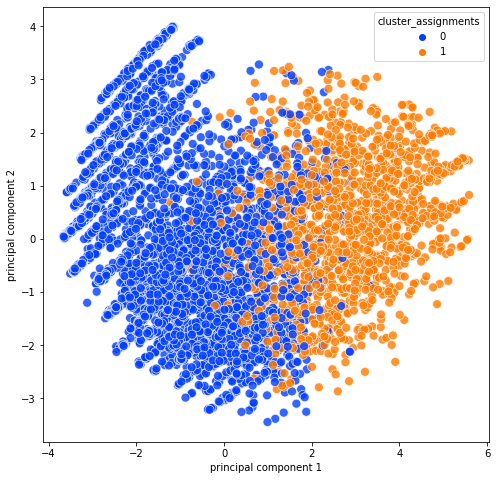

In [299]:
cluster_ass=pd.DataFrame(cluster_assignments,columns=['cluster_assignments'])
data=pd.concat([pdf,cluster_ass],axis=1)

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(x = data.iloc[:,0], y = data.iloc[:,1], hue = data.iloc[:,2],
                s = 80, alpha = 0.8, palette='bright', ax = ax)

### Kernal PCA and Clustering

In [301]:
from sklearn.decomposition import KernelPCA

pca=KernelPCA(n_components=2, kernel='rbf')
pc=pca.fit_transform(trains_X)

pdf=pd.DataFrame(data=pc,columns=['principal component 1','principal component 2'])
pdf.head()

,principal component 1,principal component 2
0,-0.316785,0.014931
1,-0.003713,-0.203034
2,0.396449,0.337337
3,0.284344,-0.211114
4,-0.042891,0.029497


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

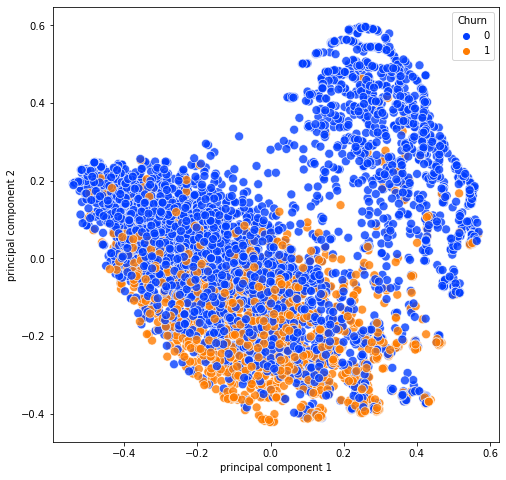

In [302]:
data=pd.concat([pdf,trains_Y],axis=1)

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(x = data.iloc[:,0], y = data.iloc[:,1], hue = data.iloc[:,2],
                s = 80, alpha = 0.8, palette='bright', ax = ax)

In [303]:
# Import KMeans from sklearn
from sklearn.cluster import KMeans

# Intantiate a KMeans object which will generate 10 clusters.
# Use init='k-means++' and random_state=123
# Store as 'km'.
km = KMeans(n_clusters = 2, init='k-means++', random_state=123)

# Use .fit_predict() on X_digits to both fit our k-means model and generate cluster assignments.
# Store the result as cluster_assignments.
cluster_assignments = km.fit_predict(train_X)

# print the first 10 cluster assignments
print(cluster_assignments[:10])

[1 0 0 0 0 0 0 0 1 0]


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

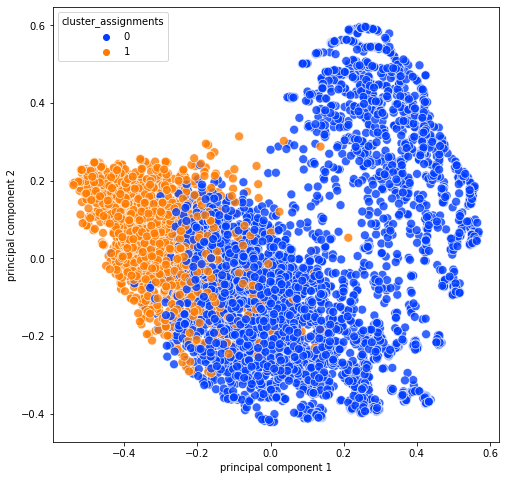

In [304]:
cluster_ass=pd.DataFrame(cluster_assignments,columns=['cluster_assignments'])
data=pd.concat([pdf,cluster_ass],axis=1)

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(x = data.iloc[:,0], y = data.iloc[:,1], hue = data.iloc[:,2],
                s = 80, alpha = 0.8, palette='bright', ax = ax)